# Frequency-switched Data Reduction
-----------------------------------

This notebook shows how to use `dysh` to calibrate a frequency switched observations. The idea is similar to an OnOff observation, except the telescope does not move to an Off in position, but move their IF in frequency space. Here we call the On/Off the Sig and Ref. Since the telescope observes in a Track mode, combining the sig and a shifted (folded) ref, a $\sqrt{2}$ improvement in S/N can be achieved.

It retrieves and calibrates frequency-switched scans using `GBTFITSLoad.getfs()`, which returns a `ScanBlock` object.  

In [1]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
import dysh.util as util
import numpy as np

## First, we load the example SDFITS data


In [2]:
filename = util.get_project_testdata()/"AGBT20B_014_03.raw.vegas/AGBT20B_014_03.raw.vegas.A6.fits"

In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.info()
sdfits.summary()

Filename: /home/mpound/src/dysh/testdata/AGBT20B_014_03.raw.vegas/AGBT20B_014_03.raw.vegas.A6.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  SINGLE DISH    1 BinTableHDU    185   88R x 83C   ['32A', 'D', '22A', 'D', 'D', 'D', '16384E', '16A', '6A', '8A', 'D', 'D', 'D', '4A', 'D', '4A', 'D', 'I', '32A', '32A', 'J', '32A', '16A', 'D', '8A', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', '8A', 'D', 'D', '8A', 'I', 'I', 'D', 'D', 'I', 'A', 'I', 'I', '16A', '16A', 'J', 'J', '22A', 'D', 'D', 'I', 'A', 'D', 'D', 'E', 'D', 'D', 'D', 'D', 'A', 'A', '8A', 'E', 'E', '16A', '32A', '32A', '32A', 'D', 'D', 'D', 'I', 'I', 'I', 'J', 'J']   


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,M33S,0.0,Track,1,1.595789,1.420405,4,2,3,1,72.213498,28.201934


### Now retrieve and calibrate the frequency-switched scan
The default is to fold the sig and ref to create the final spectrum.  Use `fold=False` to not fold them.

In [4]:
fsscan = sdfits.getfs(scan=6, ifnum=0, plnum=1)

Calibrated 3 spectra with fold=True and use_sig=True


In [5]:
ta = fsscan.timeaverage(weights='tsys')

PJT:   timeaverage


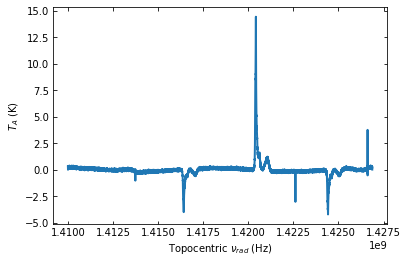

In [6]:
ta.plot()

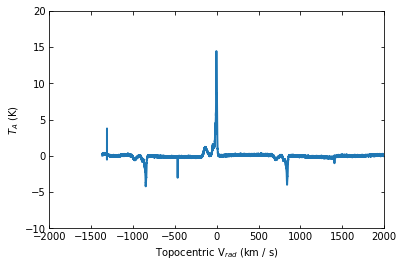

In [7]:
ta.plot(xaxis_unit="km/s",yaxis_unit="K",ymin=-10,ymax=20,xmin=-2000,xmax=2000)

In [8]:
# wait for merge of update notebooks branch
#ta.plot(xaxis_unit="chan",yaxis_unit="K",ymin=-10,ymax=20,xmin=-2000,xmax=2000)
#ta.baseline(degree=2,exclude[(x,x),(y,y),(z,z)],remove=True)

In [9]:
kms = u.km/u.s
#ta.baseline(degree=2,exclude=[(-2000*kms,-400*kms),(-200*kms,100*kms),(600*kms,3000*kms)],remove=True)
ta.baseline(degree=2,exclude=[-200*kms,100*kms],remove=True)

EXCLUDING [Spectral Region, 1 sub-regions:
  (1419929945.1210444 Hz, 1421351333.4469643 Hz) 
]


 [astropy.modeling.fitting]


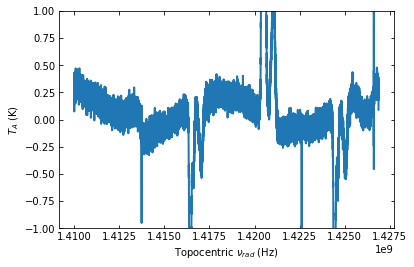

In [10]:
ta.plot(ymin=-1,ymax=1)

In [11]:
print(ta.baseline_model)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
             c0                     c1                     c2          
             K                    K / Hz                K / Hz2        
    -------------------- ----------------------- ----------------------
    -0.06743288442859696 -2.3638315696467294e-29 -8.285579698791515e-57


In [12]:
ta.savefig("baselined_removed.png")